<h1><center> Emotions in context (Emotic) </center></h1>
<center> Baseline model</center>

# I. Prepare places pretrained model

In [1]:
import os
import requests
import torch
from torch.autograd import Variable as V
import torchvision.models as models
from PIL import Image
from torchvision import transforms as trn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
from sklearn.metrics import average_precision_score, precision_recall_curve
import torch.nn as nn
import torch.optim as optim 
from torch.utils.data import Dataset, DataLoader 
from torchsummary import summary
from torchvision import transforms
from torch.optim.lr_scheduler import StepLR
from transformers import DistilBertModel, DistilBertTokenizer

In [2]:
# Create a directory to save the model
os.makedirs("places", exist_ok=True)

# URL of the ResNet model
model_url = "http://places2.csail.mit.edu/models_places365/resnet18_places365.pth.tar"
model_path = "./places/resnet18_places365.pth.tar"

# Download the model if not already downloaded
if not os.path.exists(model_path):
    print("Downloading ResNet model...")
    response = requests.get(model_url, stream=True)
    with open(model_path, "wb") as f:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)
    print("Download complete.")
else:
    print("Model already exists.")


Model already exists.


In [3]:
# Saving the model weights to use ahead in the notebook

# the architecture to use
arch = 'resnet18'
model_weight = os.path.join('./places', 'resnet18_places365.pth.tar')

# create the network architecture
model = models.__dict__[arch](num_classes=365)

#model_weight = '%s_places365.pth.tar' % arch

checkpoint = torch.load(model_weight, map_location=lambda storage, loc: storage) # model trained in GPU could be deployed in CPU machine like this!
state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()} # the data parallel layer will add 'module' before each layer name
model.load_state_dict(state_dict)
model.eval()

model.cpu()
torch.save(model.state_dict(), './places/resnet18_state_dict.pth')
print ('completed cell')

completed cell


# II. Emotic classes

## Emotic Model 

In [4]:
class EmoticSeparateEmbeddings(nn.Module):
    ''' Emotic Model with separate embedding spaces for image and text '''
    def __init__(self, context_features, body_features, embedding_dim=256):
        super(EmoticSeparateEmbeddings, self).__init__()
        self.context_features = context_features
        self.body_features = body_features
        self.embedding_dim = embedding_dim
        
        # Image embedding pathway
        self.img_fc = nn.Linear(body_features, embedding_dim)
        self.img_bn = nn.BatchNorm1d(embedding_dim)
        self.img_relu = nn.ReLU()
        
        # Text embedding pathway
        self.text_fc = nn.Linear(context_features, embedding_dim)
        self.text_bn = nn.BatchNorm1d(embedding_dim)
        self.text_relu = nn.ReLU()
        
        # Fusion layer
        self.fusion = nn.Linear(embedding_dim * 2, embedding_dim)
        self.fusion_bn = nn.BatchNorm1d(embedding_dim)
        self.fusion_relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        
        # Output layers
        self.fc_cat = nn.Linear(embedding_dim, 26)
        self.fc_cont = nn.Linear(embedding_dim, 3)

    def forward(self, x_context, x_body, return_embeddings=False):
        # Process context features (text)
        context_features = x_context.view(-1, self.context_features)
        text_embedding = self.text_fc(context_features)
        text_embedding = self.text_bn(text_embedding)
        text_embedding = self.text_relu(text_embedding)
        
        # Process body features (image)
        body_features = x_body.view(-1, self.body_features)
        img_embedding = self.img_fc(body_features)
        img_embedding = self.img_bn(img_embedding)
        img_embedding = self.img_relu(img_embedding)
        
        # Combine embeddings
        combined = torch.cat((text_embedding, img_embedding), dim=1)
        fused = self.fusion(combined)
        fused = self.fusion_bn(fused)
        fused = self.fusion_relu(fused)
        fused = self.dropout(fused)
        
        # Output predictions
        cat_out = self.fc_cat(fused)
        cont_out = self.fc_cont(fused)
        
        if return_embeddings:
            return cat_out, cont_out, text_embedding, img_embedding
        return cat_out, cont_out

## Emotic Dataset

In [5]:
class Emotic_PreDataset(Dataset):
  ''' Custom Emotic dataset class. Use preprocessed data stored in npy files. '''
  def __init__(self, x_context, x_body, y_cat, y_cont, transform, context_norm, body_norm):
    super(Emotic_PreDataset,self).__init__()
    self.x_context = x_context
    self.x_body = x_body
    self.y_cat = y_cat 
    self.y_cont = y_cont
    self.transform = transform 
    self.context_norm = transforms.Normalize(context_norm[0], context_norm[1])  # Normalizing the context image with context mean and context std
    self.body_norm = transforms.Normalize(body_norm[0], body_norm[1])           # Normalizing the body image with body mean and body std

  def __len__(self):
    return len(self.y_cat)
  
  def __getitem__(self, index):
    image_context = self.x_context[index]
    image_body = self.x_body[index]
    cat_label = self.y_cat[index]
    cont_label = self.y_cont[index]
    return self.context_norm(self.transform(image_context)), self.body_norm(self.transform(image_body)), torch.tensor(cat_label, dtype=torch.float32), torch.tensor(cont_label, dtype=torch.float32)/10.0

print ('completed cell')

completed cell


## Emotic Losses

In [6]:
class DiscreteLoss(nn.Module):
  ''' Class to measure loss between categorical emotion predictions and labels.'''
  def __init__(self, weight_type='mean', device=torch.device('cpu')):
    super(DiscreteLoss, self).__init__()
    self.weight_type = weight_type
    self.device = device
    if self.weight_type == 'mean':
      self.weights = torch.ones((1,26))/26.0
      self.weights = self.weights.to(self.device)
    elif self.weight_type == 'static':
      self.weights = torch.FloatTensor([0.1435, 0.1870, 0.1692, 0.1165, 0.1949, 0.1204, 0.1728, 0.1372, 0.1620,
         0.1540, 0.1987, 0.1057, 0.1482, 0.1192, 0.1590, 0.1929, 0.1158, 0.1907,
         0.1345, 0.1307, 0.1665, 0.1698, 0.1797, 0.1657, 0.1520, 0.1537]).unsqueeze(0)
      self.weights = self.weights.to(self.device)
    
  def forward(self, pred, target):
    if self.weight_type == 'dynamic':
      self.weights = self.prepare_dynamic_weights(target)
      self.weights = self.weights.to(self.device)
    loss = (((pred - target)**2) * self.weights)
    return loss.sum() 

  def prepare_dynamic_weights(self, target):
    target_stats = torch.sum(target, dim=0).float().unsqueeze(dim=0).cpu()
    weights = torch.zeros((1,26))
    weights[target_stats != 0 ] = 1.0/torch.log(target_stats[target_stats != 0].data + 1.2)
    weights[target_stats == 0] = 0.0001
    return weights


class ContinuousLoss_L2(nn.Module):
  ''' Class to measure loss between continuous emotion dimension predictions and labels. Using l2 loss as base. '''
  def __init__(self, margin=1):
    super(ContinuousLoss_L2, self).__init__()
    self.margin = margin
  
  def forward(self, pred, target):
    labs = torch.abs(pred - target)
    loss = labs ** 2 
    loss[ (labs < self.margin) ] = 0.0
    return loss.sum()


class ContinuousLoss_SL1(nn.Module):
  ''' Class to measure loss between continuous emotion dimension predictions and labels. Using smooth l1 loss as base. '''
  def __init__(self, margin=1):
    super(ContinuousLoss_SL1, self).__init__()
    self.margin = margin
  
  def forward(self, pred, target):
    labs = torch.abs(pred - target)
    loss = 0.5 * (labs ** 2)
    loss[ (labs > self.margin) ] = labs[ (labs > self.margin) ] - 0.5
    return loss.sum()

print ('completed cell')

completed cell


# III. Load preprocessed data

In [7]:
# Change data_src variable as per your drive
data_src = 'D:/Ruturaj/New folder (3)/Ruturaj/Smart Systems/MANAV Experiment/proj/data/emotic19/emotic_pre'

# Load training preprocessed data
train_context = np.load(os.path.join(data_src,'train_context_arr.npy'))
train_body = np.load(os.path.join(data_src,'train_body_arr.npy'))
train_cat = np.load(os.path.join(data_src,'train_cat_arr.npy'))
train_cont = np.load(os.path.join(data_src,'train_cont_arr.npy'))

# Load validation preprocessed data
val_context = np.load(os.path.join(data_src,'val_context_arr.npy'))
val_body = np.load(os.path.join(data_src,'val_body_arr.npy'))
val_cat = np.load(os.path.join(data_src,'val_cat_arr.npy'))
val_cont = np.load(os.path.join(data_src,'val_cont_arr.npy'))

# Load testing preprocessed data
test_context = np.load(os.path.join(data_src,'test_context_arr.npy'))
test_body = np.load(os.path.join(data_src,'test_body_arr.npy'))
test_cat = np.load(os.path.join(data_src,'test_cat_arr.npy'))
test_cont = np.load(os.path.join(data_src,'test_cont_arr.npy'))

# Categorical emotion classes
cat = ['Affection', 'Anger', 'Annoyance', 'Anticipation', 'Aversion', 'Confidence', 'Disapproval', 'Disconnection',
       'Disquietment', 'Doubt/Confusion', 'Embarrassment', 'Engagement', 'Esteem', 'Excitement', 'Fatigue', 'Fear',
       'Happiness', 'Pain', 'Peace', 'Pleasure', 'Sadness', 'Sensitivity', 'Suffering', 'Surprise', 'Sympathy', 'Yearning']

cat2ind = {}
ind2cat = {}
for idx, emotion in enumerate(cat):
    cat2ind[emotion] = idx
    ind2cat[idx] = emotion

print('train ', 'context ', train_context.shape, 'body', train_body.shape, 'cat ', train_cat.shape, 'cont', train_cont.shape)
print('val ', 'context ', val_context.shape, 'body', val_body.shape, 'cat ', val_cat.shape, 'cont', val_cont.shape)
print('test ', 'context ', test_context.shape, 'body', test_body.shape, 'cat ', test_cat.shape, 'cont', test_cont.shape)
print('completed cell')

train  context  (23266, 224, 224, 3) body (23266, 128, 128, 3) cat  (23266, 26) cont (23266, 3)
val  context  (3315, 224, 224, 3) body (3315, 128, 128, 3) cat  (3315, 26) cont (3315, 3)
test  context  (7203, 224, 224, 3) body (7203, 128, 128, 3) cat  (7203, 26) cont (7203, 3)
completed cell


In [8]:
batch_size = 26

context_mean = [0.4690646, 0.4407227, 0.40508908]
context_std = [0.2514227, 0.24312855, 0.24266963]
body_mean = [0.43832874, 0.3964344, 0.3706214]
body_std = [0.24784276, 0.23621225, 0.2323653]
context_norm = [context_mean, context_std]
body_norm = [body_mean, body_std]

train_transform = transforms.Compose([transforms.ToPILImage(),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
                                      transforms.ToTensor()])
test_transform = transforms.Compose([transforms.ToPILImage(),
                                     transforms.ToTensor()])

train_dataset = Emotic_PreDataset(train_context, train_body, train_cat, train_cont,
                                  train_transform, context_norm, body_norm)
val_dataset = Emotic_PreDataset(val_context, val_body, val_cat, val_cont,
                                test_transform, context_norm, body_norm)
test_dataset = Emotic_PreDataset(test_context, test_body, test_cat, test_cont,
                                 test_transform, context_norm, body_norm)

train_loader = DataLoader(train_dataset, batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

print('train loader ', len(train_loader), 'val loader ', len(val_loader), 'test', len(test_loader))
print('completed cell')

train loader  894 val loader  128 test 278
completed cell


# IV. Prepare emotic model

In [9]:
model_path_places = './places'

model_context = models.__dict__[arch](num_classes=365)
context_state_dict = torch.load(os.path.join(model_path_places, 'resnet18_state_dict.pth'))
model_context.load_state_dict(context_state_dict)

model_body = models.resnet18(pretrained=True)

# Create the new model with separate embeddings
emotic_model = EmoticSeparateEmbeddings(
    list(model_context.children())[-1].in_features, 
    list(model_body.children())[-1].in_features,
    embedding_dim=256
)

model_context = nn.Sequential(*(list(model_context.children())[:-1]))
model_body = nn.Sequential(*(list(model_body.children())[:-1]))

# print (summary(model_context, (3,224,224), device="cpu"))
# print (summary(model_body, (3,128,128), device="cpu"))

print ('completed cell')

c:\Users\admin\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\admin\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


completed cell


## Prepare optimizer

In [10]:
for param in emotic_model.parameters():
  param.requires_grad = True
for param in model_context.parameters():
  param.requires_grad = False
for param in model_body.parameters():
  param.requires_grad = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
opt = optim.Adam((list(emotic_model.parameters()) + list(model_context.parameters()) + \
                  list(model_body.parameters())), lr=0.001, weight_decay=5e-4)
scheduler = StepLR(opt, step_size=7, gamma=0.1)

disc_loss = DiscreteLoss('dynamic', device)
cont_loss_SL1 = ContinuousLoss_SL1()

print ('completed cell')

completed cell


# V. Train model

In [11]:
def train_emotic(epochs, model_path, opt, scheduler, models, disc_loss, cont_loss, cat_loss_param=0.5, cont_loss_param=0.5):
    if not os.path.exists(model_path):
        os.makedirs(model_path)
    
    min_loss = np.inf
    train_loss = list()
    val_loss = list()

    model_context, model_body, emotic_model = models

    for e in range(epochs):
        running_loss = 0.0

        emotic_model.to(device)
        model_context.to(device)
        model_body.to(device)
        
        emotic_model.train()
        model_context.train()
        model_body.train()
        
        for images_context, images_body, labels_cat, labels_cont in iter(train_loader):
            images_context = images_context.to(device)
            images_body = images_body.to(device)
            labels_cat = labels_cat.to(device)
            labels_cont = labels_cont.to(device)

            opt.zero_grad()

            pred_context = model_context(images_context)
            pred_body = model_body(images_body)

            # For the new model that returns embeddings
            if hasattr(emotic_model, 'return_embeddings'):
                pred_cat, pred_cont, _, _ = emotic_model(pred_context, pred_body, return_embeddings=True)
            else:
                pred_cat, pred_cont = emotic_model(pred_context, pred_body)
                
            cat_loss_batch = disc_loss(pred_cat, labels_cat)
            cont_loss_batch = cont_loss(pred_cont * 10, labels_cont * 10)
            loss = (cat_loss_param * cat_loss_batch) + (cont_loss_param * cont_loss_batch)
            running_loss += loss.item()
            loss.backward()
            opt.step()

        if e % 1 == 0: 
            print(f'epoch = {e} training loss = {running_loss:.4f}')
        train_loss.append(running_loss)

        
        running_loss = 0.0 
        emotic_model.eval()
        model_context.eval()
        model_body.eval()
        
        with torch.no_grad():
            for images_context, images_body, labels_cat, labels_cont in iter(val_loader):
                images_context = images_context.to(device)
                images_body = images_body.to(device)
                labels_cat = labels_cat.to(device)
                labels_cont = labels_cont.to(device)

                pred_context = model_context(images_context)
                pred_body = model_body(images_body)
                
                # For the new model that returns embeddings
                if hasattr(emotic_model, 'return_embeddings'):
                    pred_cat, pred_cont, _, _ = emotic_model(pred_context, pred_body, return_embeddings=True)
                else:
                    pred_cat, pred_cont = emotic_model(pred_context, pred_body)
                    
                cat_loss_batch = disc_loss(pred_cat, labels_cat)
                cont_loss_batch = cont_loss(pred_cont * 10, labels_cont * 10)
                loss = (cat_loss_param * cat_loss_batch) + (cont_loss_param * cont_loss_batch)
                running_loss += loss.item()

            if e % 1 == 0:
                print(f'epoch = {e} validation loss = {running_loss:.4f}')
        val_loss.append(running_loss)
          
        scheduler.step()

        if val_loss[-1] < min_loss:
            min_loss = val_loss[-1]
            # saving models for lowest loss
            print(f'saving model at epoch e = {e}')
            emotic_model.to("cpu")
            model_context.to("cpu")
            model_body.to("cpu")
            torch.save(emotic_model, os.path.join(model_path, 'model_emotic1.pth'))
            torch.save(model_context, os.path.join(model_path, 'model_context1.pth'))
            torch.save(model_body, os.path.join(model_path, 'model_body1.pth'))

    print('completed training')
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 6))
    f.suptitle('emotic')
    ax1.plot(range(0, len(train_loss)), train_loss, color='Blue')
    ax2.plot(range(0, len(val_loss)), val_loss, color='Red')
    ax1.legend(['train'])
    ax2.legend(['val'])
    plt.savefig(os.path.join(model_path, 'loss_curves.png'))

epoch = 0 training loss = 62931.6640
epoch = 0 validation loss = 6154.2493
saving model at epoch e = 0
epoch = 1 training loss = 47485.1382
epoch = 1 validation loss = 5994.3333
saving model at epoch e = 1
epoch = 2 training loss = 45631.0784
epoch = 2 validation loss = 5890.7401
saving model at epoch e = 2
epoch = 3 training loss = 44194.2819
epoch = 3 validation loss = 5724.4397
saving model at epoch e = 3
epoch = 4 training loss = 43156.0935
epoch = 4 validation loss = 5508.8069
saving model at epoch e = 4
epoch = 5 training loss = 42421.6583
epoch = 5 validation loss = 5620.4047
epoch = 6 training loss = 42220.4918
epoch = 6 validation loss = 5613.6463
epoch = 7 training loss = 41317.2901
epoch = 7 validation loss = 5511.5631
epoch = 8 training loss = 40902.0355
epoch = 8 validation loss = 5539.2129
epoch = 9 training loss = 40700.9644
epoch = 9 validation loss = 5496.2922
saving model at epoch e = 9
epoch = 10 training loss = 40539.7864
epoch = 10 validation loss = 5519.0454
epoch

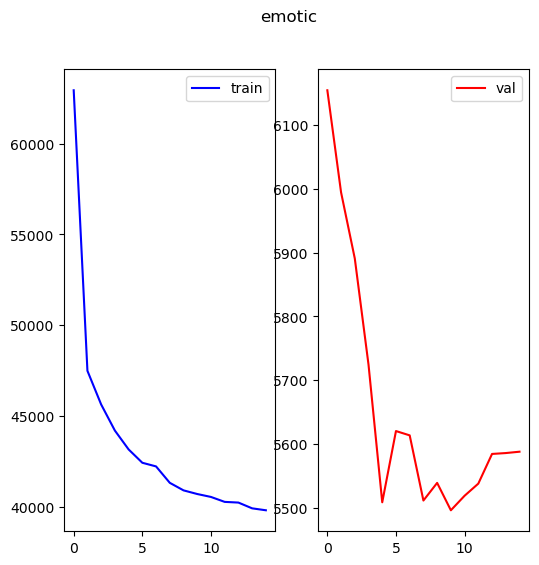

In [12]:
train_emotic(15, './models', opt, scheduler, [model_context, model_body, emotic_model], disc_loss, cont_loss_SL1)

# VI. Test model

In [13]:
def test_scikit_ap(cat_preds, cat_labels):
    ap = np.zeros(26, dtype=np.float32)
    for i in range(26):
        ap[i] = average_precision_score(cat_labels[i, :], cat_preds[i, :])
    print('ap', ap, ap.shape, ap.mean())
    return ap.mean()


def test_emotic_vad(cont_preds, cont_labels):
    vad = np.zeros(3, dtype=np.float32)
    for i in range(3):
        vad[i] = np.mean(np.abs(cont_preds[i, :] - cont_labels[i, :]))
    print('vad', vad, vad.shape, vad.mean())
    return vad.mean()


def get_thresholds(cat_preds, cat_labels):
    thresholds = np.zeros(26, dtype=np.float32)
    for i in range(26):
        p, r, t = precision_recall_curve(cat_labels[i, :], cat_preds[i, :])
        for k in range(len(p)):
            if p[k] == r[k]:
                thresholds[i] = t[k]
                break
    np.save('./thresholds.npy', thresholds)
    return thresholds

print ('completed cell')

completed cell


In [14]:
def test_data(models, device, data_loader, num_images):
    model_context, model_body, emotic_model = models
    cat_preds = np.zeros((num_images, 26))
    cat_labels = np.zeros((num_images, 26))
    cont_preds = np.zeros((num_images, 3))
    cont_labels = np.zeros((num_images, 3))

    with torch.no_grad():
        model_context.to(device)
        model_body.to(device)
        emotic_model.to(device)
        model_context.eval()
        model_body.eval()
        emotic_model.eval()
        indx = 0
        print('starting testing')
        for images_context, images_body, labels_cat, labels_cont in iter(data_loader):
            images_context = images_context.to(device)
            images_body = images_body.to(device)

            pred_context = model_context(images_context)
            pred_body = model_body(images_body)
            
            # For the new model that returns embeddings
            if hasattr(emotic_model, 'return_embeddings'):
                pred_cat, pred_cont, _, _ = emotic_model(pred_context, pred_body, return_embeddings=True)
            else:
                pred_cat, pred_cont = emotic_model(pred_context, pred_body)

            cat_preds[indx : (indx + pred_cat.shape[0]), :] = pred_cat.to("cpu").data.numpy()
            cat_labels[indx : (indx + labels_cat.shape[0]), :] = labels_cat.to("cpu").data.numpy()
            cont_preds[indx : (indx + pred_cont.shape[0]), :] = pred_cont.to("cpu").data.numpy() * 10
            cont_labels[indx : (indx + labels_cont.shape[0]), :] = labels_cont.to("cpu").data.numpy() * 10 
            indx = indx + pred_cat.shape[0]

    cat_preds = cat_preds.transpose()
    cat_labels = cat_labels.transpose()
    cont_preds = cont_preds.transpose()
    cont_labels = cont_labels.transpose()
    scipy.io.savemat('./cat_preds.mat', mdict={'cat_preds': cat_preds})
    scipy.io.savemat('./cat_labels.mat', mdict={'cat_labels': cat_labels})
    scipy.io.savemat('./cont_preds.mat', mdict={'cont_preds': cont_preds})
    scipy.io.savemat('./cont_labels.mat', mdict={'cont_labels': cont_labels})
    print('completed testing')
    ap_mean = test_scikit_ap(cat_preds, cat_labels)
    vad_mean = test_emotic_vad(cont_preds, cont_labels)
    print(ap_mean, vad_mean)
    return ap_mean, vad_mean

print ('completed cell')

completed cell


# VII. Embedding Space Analysis

In [31]:
def test_embedding_spaces(models, device, data_loader, num_samples=1000):
    """Test the model and analyze the embedding spaces"""
    model_context, model_body, emotic_model = models
    
    # Storage for embeddings and predictions
    text_embeddings = []
    img_embeddings = []
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        model_context.to(device)
        model_body.to(device)
        emotic_model.to(device)
        model_context.eval()
        model_body.eval()
        emotic_model.eval()
        
        count = 0
        for images_context, images_body, labels_cat, labels_cont in iter(data_loader):
            if count >= num_samples:
                break
                
            images_context = images_context.to(device)
            images_body = images_body.to(device)
            
            # Extract features
            pred_context = model_context(images_context)
            pred_body = model_body(images_body)
            
            # Store the raw feature embeddings
            text_embeddings.append(pred_context.view(pred_context.size(0), -1).cpu().numpy())
            img_embeddings.append(pred_body.view(pred_body.size(0), -1).cpu().numpy())
            
            # Get predictions
            pred_cat, pred_cont = emotic_model(pred_context, pred_body)
            
            # Store predictions and labels
            predictions.append(pred_cat.cpu().numpy())
            true_labels.append(labels_cat.cpu().numpy())
            
            count += images_context.size(0)
    
    # Concatenate results
    text_embeddings = np.vstack(text_embeddings)
    img_embeddings = np.vstack(img_embeddings)
    predictions = np.vstack(predictions)
    true_labels = np.vstack(true_labels)
    
    return text_embeddings, img_embeddings, predictions, true_labels

In [32]:
def analyze_embedding_robustness(text_emb, img_emb, predictions, labels):
    """Analyze the robustness of the embedding spaces"""
    
    # 1. Visualize embeddings with t-SNE
    from sklearn.manifold import TSNE
    
    # Reduce dimensionality for visualization
    tsne = TSNE(n_components=2, random_state=42)
    text_tsne = tsne.fit_transform(text_emb[:500])  # Using subset for speed
    
    tsne = TSNE(n_components=2, random_state=42)
    img_tsne = tsne.fit_transform(img_emb[:500])  # Using subset for speed
    
    # Plot embeddings
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.scatter(text_tsne[:, 0], text_tsne[:, 1], alpha=0.5)
    plt.title('Text Embedding Space')
    
    plt.subplot(1, 2, 2)
    plt.scatter(img_tsne[:, 0], img_tsne[:, 1], alpha=0.5)
    plt.title('Image Embedding Space')
    
    plt.tight_layout()
    plt.savefig('embedding_spaces.png')
    
    # 2. Calculate embedding space statistics
    text_variance = np.var(text_emb, axis=0).mean()
    img_variance = np.var(img_emb, axis=0).mean()
    
    # 3. Measure cosine similarity within each embedding space
    from sklearn.metrics.pairwise import cosine_similarity
    
    # Sample a subset for efficiency
    sample_size = min(500, text_emb.shape[0])
    text_sample = text_emb[:sample_size]
    img_sample = img_emb[:sample_size]
    
    text_sim = cosine_similarity(text_sample)
    img_sim = cosine_similarity(img_sample)
    
    # Average similarity (excluding self-similarity)
    text_avg_sim = (text_sim.sum() - text_sim.trace()) / (text_sim.size - text_sim.shape[0])
    img_avg_sim = (img_sim.sum() - img_sim.trace()) / (img_sim.size - img_sim.shape[0])
    
    # 4. Calculate feature importance
    # We'll use a simple correlation analysis between features and predictions
    from scipy.stats import pearsonr
    
    # For each emotion category, find most correlated features
    text_importance = np.zeros(text_emb.shape[1])
    img_importance = np.zeros(img_emb.shape[1])
    
    # Use first emotion category for simplicity
    for i in range(min(5, predictions.shape[1])):  # First 5 emotions
        for j in range(text_emb.shape[1]):
            corr, _ = pearsonr(text_emb[:, j], predictions[:, i])
            text_importance[j] += abs(corr)
            
        for j in range(img_emb.shape[1]):
            corr, _ = pearsonr(img_emb[:, j], predictions[:, i])
            img_importance[j] += abs(corr)
    
    # Normalize
    text_importance /= 5
    img_importance /= 5
    
    # Top important features
    text_top_features = np.argsort(text_importance)[-10:]
    img_top_features = np.argsort(img_importance)[-10:]
    
    results = {
        "text_embedding_variance": text_variance,
        "image_embedding_variance": img_variance,
        "text_avg_similarity": text_avg_sim,
        "image_avg_similarity": img_avg_sim,
        "text_top_features": text_top_features,
        "img_top_features": img_top_features,
        "text_importance": text_importance,  
        "img_importance": img_importance
    }
    
    return results

In [33]:
def test_with_noise(models, device, data_loader, noise_levels=[0.1, 0.3, 0.5]):
    """Test model robustness by adding noise to each modality separately"""
    model_context, model_body, emotic_model = models
    results = {}
    
    # Baseline performance (no noise)
    baseline_ap, baseline_vad = test_data(models, device, data_loader, data_loader.dataset.__len__())
    results["baseline"] = {"ap": baseline_ap, "vad": baseline_vad}
    
    # Test with noise in text modality
    for noise_level in noise_levels:
        # Function to test with noise in context features
        def test_with_text_noise(noise_level):
            cat_preds = []
            cat_labels = []
            cont_preds = []
            cont_labels = []
            
            with torch.no_grad():
                model_context.eval()
                model_body.eval()
                emotic_model.eval()
                
                for images_context, images_body, labels_cat, labels_cont in iter(data_loader):
                    images_context = images_context.to(device)
                    images_body = images_body.to(device)
                    
                    # Extract features
                    pred_context = model_context(images_context)
                    pred_body = model_body(images_body)
                    
                    # Add noise to text features
                    noise = torch.randn_like(pred_context) * noise_level * pred_context.std()
                    pred_context_noisy = pred_context + noise
                    
                    # Get predictions
                    pred_cat, pred_cont = emotic_model(pred_context_noisy, pred_body)
                    
                    cat_preds.append(pred_cat.cpu().numpy())
                    cat_labels.append(labels_cat.cpu().numpy())
                    cont_preds.append(pred_cont.cpu().numpy() * 10)
                    cont_labels.append(labels_cont.cpu().numpy() * 10)
            
            # Calculate metrics
            cat_preds = np.vstack(cat_preds).transpose()
            cat_labels = np.vstack(cat_labels).transpose()
            cont_preds = np.vstack(cont_preds).transpose()
            cont_labels = np.vstack(cont_labels).transpose()
            
            ap = test_scikit_ap(cat_preds, cat_labels)
            vad = test_emotic_vad(cont_preds, cont_labels)
            return ap, vad
        
        print(f"Testing with {noise_level} noise in text features")
        text_ap, text_vad = test_with_text_noise(noise_level)
        results[f"text_noise_{noise_level}"] = {"ap": text_ap, "vad": text_vad}
    
    # Test with noise in image modality
    for noise_level in noise_levels:
        # Function to test with noise in body features
        def test_with_image_noise(noise_level):
            cat_preds = []
            cat_labels = []
            cont_preds = []
            cont_labels = []
            
            with torch.no_grad():
                model_context.eval()
                model_body.eval()
                emotic_model.eval()
                
                for images_context, images_body, labels_cat, labels_cont in iter(data_loader):
                    images_context = images_context.to(device)
                    images_body = images_body.to(device)
                    
                    # Extract features
                    pred_context = model_context(images_context)
                    pred_body = model_body(images_body)
                    
                    # Add noise to image features
                    noise = torch.randn_like(pred_body) * noise_level * pred_body.std()
                    pred_body_noisy = pred_body + noise
                    
                    # Get predictions
                    pred_cat, pred_cont = emotic_model(pred_context, pred_body_noisy)
                    
                    cat_preds.append(pred_cat.cpu().numpy())
                    cat_labels.append(labels_cat.cpu().numpy())
                    cont_preds.append(pred_cont.cpu().numpy() * 10)
                    cont_labels.append(labels_cont.cpu().numpy() * 10)
            
            # Calculate metrics
            cat_preds = np.vstack(cat_preds).transpose()
            cat_labels = np.vstack(cat_labels).transpose()
            cont_preds = np.vstack(cont_preds).transpose()
            cont_labels = np.vstack(cont_labels).transpose()
            
            ap = test_scikit_ap(cat_preds, cat_labels)
            vad = test_emotic_vad(cont_preds, cont_labels)
            return ap, vad
        
        print(f"Testing with {noise_level} noise in image features")
        img_ap, img_vad = test_with_image_noise(noise_level)
        results[f"image_noise_{noise_level}"] = {"ap": img_ap, "vad": img_vad}
    
    return results


# VIII. Run the analysis

In [34]:
print('Loading trained models')
model_context = torch.load('./models/model_context1.pth', weights_only=False)
model_body = torch.load('./models/model_body1.pth', weights_only=False)
emotic_model = torch.load('./models/model_emotic1.pth', weights_only=False)

Loading trained models


In [35]:
print('Running baseline evaluation')
val_ap, val_vad = test_data([model_context, model_body, emotic_model], device, val_loader, val_dataset.__len__())
test_ap, test_vad = test_data([model_context, model_body, emotic_model], device, test_loader, test_dataset.__len__())

Running baseline evaluation
starting testing
completed testing
ap [0.38716793 0.17155817 0.22017029 0.95089984 0.1777658  0.7933602
 0.23642102 0.371202   0.18806623 0.21772546 0.06170461 0.98100704
 0.24395029 0.7999282  0.14686657 0.09492898 0.8141162  0.17229061
 0.30264604 0.5006716  0.21056859 0.07694612 0.20226675 0.13953406
 0.33337444 0.11593357] (26,) 0.3427335
vad [0.69755876 0.8630178  0.8667325 ] (3,) 0.809103
0.3427335 0.809103
starting testing
completed testing
ap [0.29371274 0.08971833 0.1392061  0.5633614  0.06743938 0.76185584
 0.12433915 0.24160628 0.1664311  0.17625788 0.02066736 0.8675522
 0.14988866 0.6963364  0.10359154 0.06570021 0.6689479  0.08354216
 0.22003287 0.43330988 0.18531321 0.06526645 0.19962917 0.09242458
 0.13611536 0.08410731] (26,) 0.2575521
vad [0.8970982  1.0245683  0.94569486] (3,) 0.9557871
0.2575521 0.9557871


In [36]:
print('validation Mean average precision=%.4f Mean VAD MAE=%.4f' % (val_ap, val_vad))
print('testing Mean average precision=%.4f Mean VAD MAE=%.4f' % (test_ap, test_vad))

validation Mean average precision=0.3427 Mean VAD MAE=0.8091
testing Mean average precision=0.2576 Mean VAD MAE=0.9558


In [37]:
# Analyze embedding spaces
print('Analyzing embedding spaces')
text_emb, img_emb, preds, labels = test_embedding_spaces(
    [model_context, model_body, emotic_model], 
    device, 
    test_loader,
    num_samples=500  # Limit samples for faster processing
)


Analyzing embedding spaces



Embedding Space Statistics:
text_embedding_variance: 0.28345757722854614
image_embedding_variance: 1.1473037004470825
text_avg_similarity: 0.4723
image_avg_similarity: 0.4581
text_top_features: [504 401 424 377 131 324 419 216 100 263]
img_top_features: [378 193 341 209 147 495 375  57  49 408]
text_importance: [0.1440275  0.17711218 0.13274597 0.0569513  0.09338592 0.06478797
 0.03030022 0.02026831 0.1068759  0.12813484 0.16613662 0.06434155
 0.10868311 0.04542344 0.03771133 0.19367029 0.17249584 0.12415984
 0.0667154  0.06806224 0.02007113 0.05125328 0.14754786 0.05621235
 0.09165518 0.07892591 0.10660165 0.15801049 0.05605795 0.04231455
 0.13889693 0.19461941 0.04624416 0.06200099 0.08362516 0.10375197
 0.11907777 0.22418672 0.25116244 0.06348539 0.06359402 0.13711827
 0.06094918 0.09794416 0.23813553 0.06718473 0.05838642 0.23145655
 0.10790767 0.11843635 0.12954913 0.07918236 0.11763942 0.07923332
 0.12517788 0.038915   0.13108727 0.05472521 0.16017628 0.03027614
 0.15165339 0.19

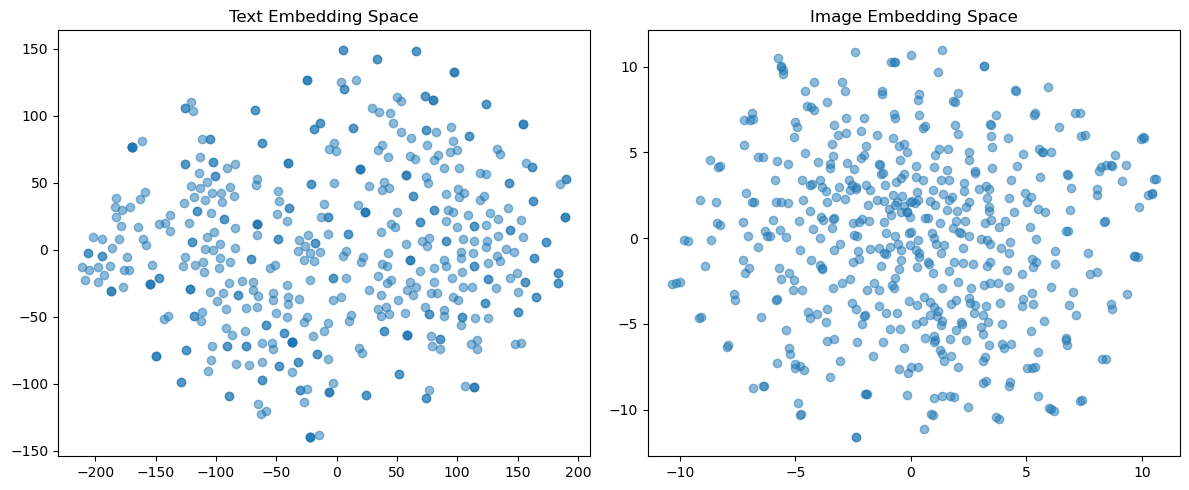

In [38]:
# Get robustness results
robustness_stats = analyze_embedding_robustness(text_emb, img_emb, preds, labels)
print("\nEmbedding Space Statistics:")
for key, value in robustness_stats.items():
    if isinstance(value, float):
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}: {value}")

In [39]:
# Test robustness to noise
print('\nTesting robustness to noise')
noise_results = test_with_noise(
    [model_context, model_body, emotic_model],
    device,
    test_loader,
    noise_levels=[0.1, 0.3, 0.5]
)


Testing robustness to noise
starting testing
completed testing
ap [0.29371274 0.08971833 0.1392061  0.5633614  0.06743938 0.76185584
 0.12433915 0.24160628 0.1664311  0.17625788 0.02066736 0.8675522
 0.14988866 0.6963364  0.10359154 0.06570021 0.6689479  0.08354216
 0.22003287 0.43330988 0.18531321 0.06526645 0.19962917 0.09242458
 0.13611536 0.08410731] (26,) 0.2575521
vad [0.8970982  1.0245683  0.94569486] (3,) 0.9557871
0.2575521 0.9557871
Testing with 0.1 noise in text features
ap [0.29418024 0.08994014 0.1398415  0.56337863 0.06798907 0.76167524
 0.12410323 0.24122453 0.16637981 0.17623231 0.0206892  0.8674124
 0.14959924 0.6962901  0.1031184  0.06571917 0.6685279  0.0842329
 0.22072981 0.4330845  0.18490736 0.06514425 0.20008531 0.09226169
 0.13589145 0.08438334] (26,) 0.25757778
vad [0.89693964 1.0249652  0.945833  ] (3,) 0.9559126
Testing with 0.3 noise in text features
ap [0.2924466  0.08506197 0.13913141 0.5639972  0.0659031  0.761137
 0.12150187 0.24149027 0.16466412 0.1745

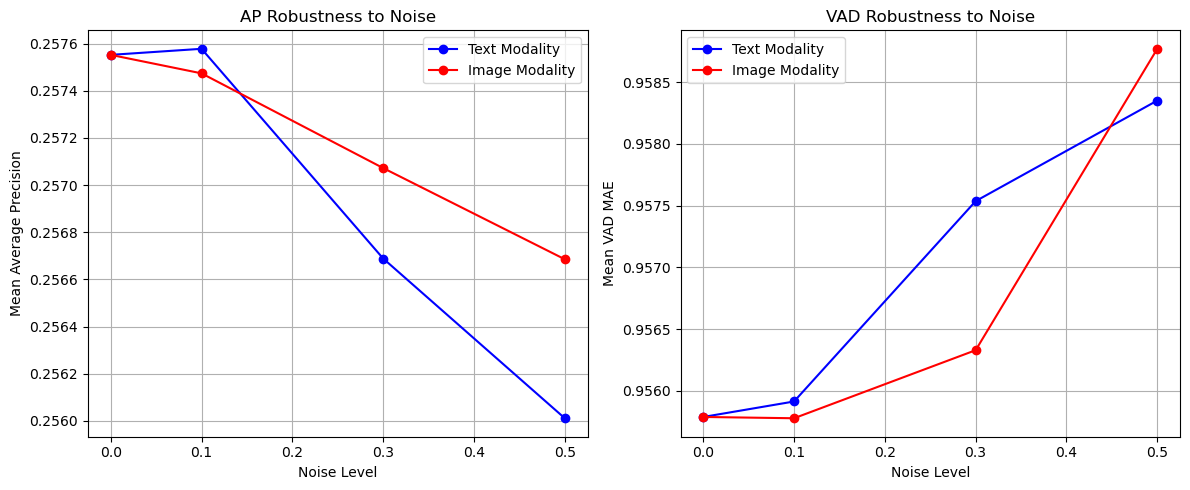

In [40]:
# Plot noise robustness results
plt.figure(figsize=(12, 5))

# Plot for AP (Mean Average Precision)
plt.subplot(1, 2, 1)
noise_levels = [0, 0.1, 0.3, 0.5]  # 0 is baseline
text_ap = [noise_results["baseline"]["ap"]] + [noise_results[f"text_noise_{nl}"]["ap"] for nl in noise_levels[1:]]
img_ap = [noise_results["baseline"]["ap"]] + [noise_results[f"image_noise_{nl}"]["ap"] for nl in noise_levels[1:]]

plt.plot(noise_levels, text_ap, 'b-o', label='Text Modality')
plt.plot(noise_levels, img_ap, 'r-o', label='Image Modality')
plt.xlabel('Noise Level')
plt.ylabel('Mean Average Precision')
plt.title('AP Robustness to Noise')
plt.legend()
plt.grid(True)

# Plot for VAD (Valence-Arousal-Dominance)
plt.subplot(1, 2, 2)
text_vad = [noise_results["baseline"]["vad"]] + [noise_results[f"text_noise_{nl}"]["vad"] for nl in noise_levels[1:]]
img_vad = [noise_results["baseline"]["vad"]] + [noise_results[f"image_noise_{nl}"]["vad"] for nl in noise_levels[1:]]

plt.plot(noise_levels, text_vad, 'b-o', label='Text Modality')
plt.plot(noise_levels, img_vad, 'r-o', label='Image Modality')
plt.xlabel('Noise Level')
plt.ylabel('Mean VAD MAE')
plt.title('VAD Robustness to Noise')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('modality_robustness.png')
plt.show()

In [41]:
# Calculate relative performance degradation
print("\nRelative Performance Degradation (AP):")
for nl in noise_levels[1:]:
    text_degradation = (noise_results["baseline"]["ap"] - noise_results[f"text_noise_{nl}"]["ap"]) / noise_results["baseline"]["ap"] * 100
    img_degradation = (noise_results["baseline"]["ap"] - noise_results[f"image_noise_{nl}"]["ap"]) / noise_results["baseline"]["ap"] * 100
    print(f"Noise level {nl}: Text: {text_degradation:.2f}%, Image: {img_degradation:.2f}%")



Relative Performance Degradation (AP):
Noise level 0.1: Text: -0.01%, Image: 0.03%
Noise level 0.3: Text: 0.34%, Image: 0.19%
Noise level 0.5: Text: 0.60%, Image: 0.34%


In [42]:
# Determine which modality is more robust
max_text_degradation = max([(noise_results["baseline"]["ap"] - noise_results[f"text_noise_{nl}"]["ap"]) / noise_results["baseline"]["ap"] * 100 for nl in noise_levels[1:]])
max_img_degradation = max([(noise_results["baseline"]["ap"] - noise_results[f"image_noise_{nl}"]["ap"]) / noise_results["baseline"]["ap"] * 100 for nl in noise_levels[1:]])

print("\nRobustness Analysis:")
if max_text_degradation < max_img_degradation:
    print("The text modality is more robust to noise than the image modality.")
    print(f"Maximum degradation: Text: {max_text_degradation:.2f}%, Image: {max_img_degradation:.2f}%")
else:
    print("The image modality is more robust to noise than the text modality.")
    print(f"Maximum degradation: Text: {max_text_degradation:.2f}%, Image: {max_img_degradation:.2f}%")


Robustness Analysis:
The image modality is more robust to noise than the text modality.
Maximum degradation: Text: 0.60%, Image: 0.34%


In [43]:
# Analyze embedding space characteristics
print("\nEmbedding Space Characteristics:")
print(f"Text embedding variance: {robustness_stats['text_embedding_variance']:.4f}")
print(f"Image embedding variance: {robustness_stats['image_embedding_variance']:.4f}")
print(f"Text average similarity: {robustness_stats['text_avg_similarity']:.4f}")
print(f"Image average similarity: {robustness_stats['image_avg_similarity']:.4f}")



Embedding Space Characteristics:
Text embedding variance: 0.2835
Image embedding variance: 1.1473
Text average similarity: 0.4723
Image average similarity: 0.4581


In [44]:
# Compare embedding spaces
print("\nEmbedding Space Comparison:")
if robustness_stats['text_embedding_variance'] > robustness_stats['image_embedding_variance']:
    print("Text embeddings have higher variance, suggesting more diverse representations.")
else:
    print("Image embeddings have higher variance, suggesting more diverse representations.")

if robustness_stats['text_avg_similarity'] > robustness_stats['image_avg_similarity']:
    print("Text embeddings have higher average similarity, suggesting more clustered representations.")
else:
    print("Image embeddings have higher average similarity, suggesting more clustered representations.")


Embedding Space Comparison:
Image embeddings have higher variance, suggesting more diverse representations.
Text embeddings have higher average similarity, suggesting more clustered representations.


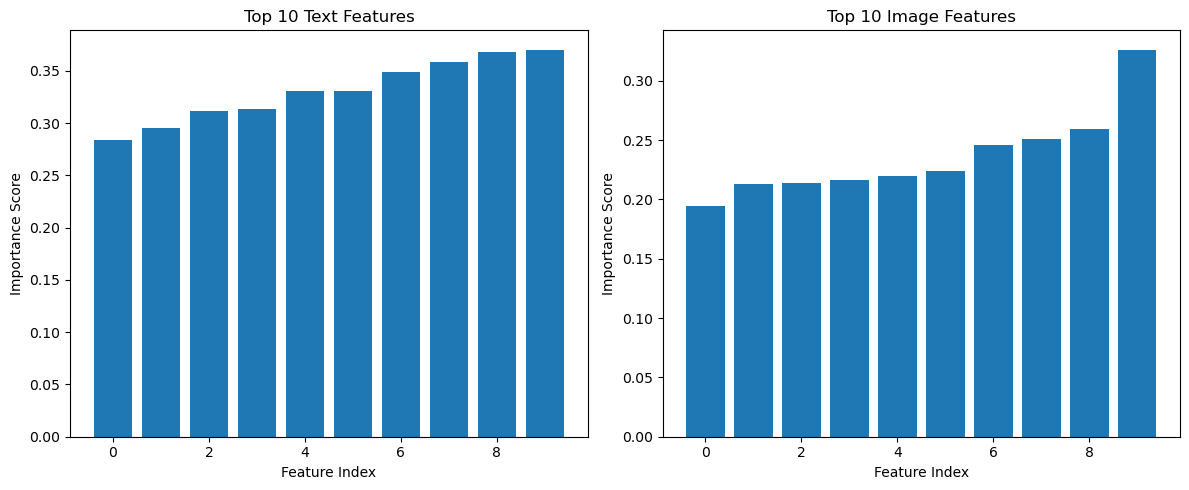

In [45]:
# Visualize top features
# Visualize top features
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(range(10), [robustness_stats['text_importance'][i] for i in robustness_stats['text_top_features']])
plt.title('Top 10 Text Features')
plt.xlabel('Feature Index')
plt.ylabel('Importance Score')

plt.subplot(1, 2, 2)
plt.bar(range(10), [robustness_stats['img_importance'][i] for i in robustness_stats['img_top_features']])
plt.title('Top 10 Image Features')
plt.xlabel('Feature Index')
plt.ylabel('Importance Score')

plt.tight_layout()
plt.savefig('top_features.png')
plt.show()


# IX. Conclusion and Recommendations


Conclusion and Recommendations:
1. The image modality is more robust to noise, suggesting it provides more reliable information.
2. Consider increasing the weight of image features in the fusion process.
3. For critical applications, image inputs should be prioritized over text inputs.

General recommendations:
1. Implement an attention mechanism to dynamically weight modalities based on input quality.
2. Consider adding regularization to the less robust modality to improve its performance.
3. For deployment, implement confidence scores based on embedding characteristics.
4. Explore adversarial training to further improve robustness of both modalities.
